In [27]:
import ast
import os
import glob
import numpy as np
import datetime
import xarray as xr
import nc_time_axis
import itertools
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cftime
from scipy.interpolate import interp1d
from src.load_SAIdata import Cases
%matplotlib inline

In [3]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    'RCP8.5': ('RCP',2092,'rcp'), 
    'SAI2050': ('SAI',2092,'sai')
}

datadir = "../../tracker/data/"
#datadir = "/home/jasperdj/files_rene/"

ds = {exp: [] for exp in open_kwargs}
for exp, (name, year, tag) in open_kwargs.items():
    maxtn = 0
    num_days = 0
    for n in range(1,6):
        fname = f'{name}.started_{year}.00{n}/TC_tracker_results.{tag}.started_{year}.00{n}.nc'
        fname = os.path.join(datadir, fname)
        if os.path.exists(fname):
            dsi = xr.open_dataset(fname, decode_cf=False)
            # # test start
            # for tid in dsi.id.data:
            #     lons = dsi.TC_tracks.isel(data=1).sel(id=tid)
            #     lons[lons>1e30] = np.nan
            #     if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            #         print(exp, n, tid, lons.values[5:10])
            # # test end
            dsi = (dsi.assign_coords(id=('id',dsi.id.data+maxtn,dsi.id.attrs))
                   .assign_coords(ens=('id',np.ones(dsi.id.size)*n,{'long_name':'ensemble member'})))
            ds[exp].append(dsi)
            maxtn = dsi.id.max().item()
            times = dsi.TC_tracks.isel(data=0)
            num_days += dsi.num_days
            print(f'{tag.upper()}.00{n}: {dsi.num_days/365:.3f} years, {len(dsi.id)} tracks')
    ds[exp] = xr.concat(ds[exp], data_vars='minimal', dim='id')
    ds[exp]['num_days'] = num_days.assign_attrs({'long_name':'total number of analysed days'})


for k,v in ds.items():
    for i,(desc) in enumerate(v.data.description):
        shortname = desc[:desc.index(':')]
        v[shortname] = v.TC_tracks.isel(data=i).assign_attrs(
            ast.literal_eval(desc[desc.index(':')+1:]))
        v[shortname].data[v[shortname]>1e30] = np.nan
    time = v.time.copy()
    tmask = np.isnan(time)
    time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
    ctime = time - datetime.timedelta(hours=1, minutes=30)
    #time -= 0.0625 # set to center of CESM time bounds (only for year determination)
    #tmask = np.isnan(time)
    #time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
    v['year'] = ctime.dt.year.where(~tmask, np.nan) # at center of CESM time bounds #time.dt.year.where(~tmask, np.nan)
    v['cftime'] = time.where(~tmask, np.nan) #.where(~tmask, np.nan) + 
    v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
    v['PRECT'].attrs.update({'units':'mm/hour'})


# There are a handful of NaNs in longitude in otherwise fine trajectories
# fixing manually...
for exp in ds:
    for tid in ds[exp].id.astype('int').data:
        dsi = ds[exp].sel(id=tid)
        if np.isnan(dsi.lon[7]):
            dsi.lon[7] = dsi.lon[6]
            print(f"{exp} {tid=}: changing lon=NaN at dtime=7 to {dsi.lon.data[6]:.3f}")
            ds[exp].loc[dict(id=tid)]['lon'] = dsi.lon
        if np.isnan(dsi.lon[8]):
            dsi.lon[8] = dsi.lon[9]
            print(f"{exp} {tid=}: changing lon=NaN at dtime=8 to {dsi.lon.data[9]:.3f}")
            ds[exp].loc[dict(id=tid)]['lon'] = dsi.lon

REF.001: 5.000 years, 478 tracks
REF.002: 5.000 years, 485 tracks
REF.003: 5.000 years, 495 tracks
REF.004: 5.000 years, 499 tracks
REF.005: 5.000 years, 521 tracks
RCP.001: 5.000 years, 447 tracks
RCP.002: 5.000 years, 438 tracks
RCP.003: 5.000 years, 465 tracks
RCP.004: 5.000 years, 465 tracks
RCP.005: 5.000 years, 457 tracks
SAI.001: 5.000 years, 426 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 413 tracks
SAI.004: 5.000 years, 433 tracks
SAI.005: 5.000 years, 405 tracks
Reference tid=585: changing lon=NaN at dtime=7 to 100.312
Reference tid=585: changing lon=NaN at dtime=8 to 100.000
Reference tid=790: changing lon=NaN at dtime=7 to 100.625
Reference tid=858: changing lon=NaN at dtime=8 to 99.062
Reference tid=1158: changing lon=NaN at dtime=7 to 100.312
Reference tid=1158: changing lon=NaN at dtime=8 to 100.000
Reference tid=1191: changing lon=NaN at dtime=7 to 100.312
Reference tid=2087: changing lon=NaN at dtime=7 to 100.000
SAI2050 tid=154: changing lon=NaN at d

In [3]:
# # Print any remaining unexpected NaNs...
# for exp in ds:
#     for tid in ds[exp].id.data:
#         lons = ds[exp].lon.sel(id=tid)
#         if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
#             print(exp, n, tid, lons.values[:])

In [ ]:
ds_tracks = ds['Reference'].where(ds['Reference'].ens==1, drop=True)
ds_cam = {stream: Cases('hres.ref.1').select('atm',stream).open_mfdataset(decode_cf=False) for stream in ['h1','h2']}

In [ ]:
def preprocess_precipitation(data):
    """convert to 6-hourly average precipitation in mm/hour and center time stamps"""
    da = data.PRECT.copy()
    da.data *= 3.6e6
    da.attrs['units'] = 'mm/hour'
    dt = (da.time[1] - da.time[0]).dt.total_seconds().item() # time step (s)
    if 'time: mean' in getattr(da,'cell_methods',''): # set time to center of interval
        da['time'] = ('time', (da.time - datetime.timedelta(seconds=dt/2)).data, da.time.attrs)
    if dt == 10800: # convert 3hrly to 6hrly average
        t = da.time.coarsen(time=2).mean(keep_attrs=True) 
        da = da.coarsen(time=2).mean(keep_attrs=True)
        da['time'] = t
    return da

pcip = preprocess_precipitation(ds_cam['h2'])

In [5]:
%%time
track = ds_tracks.isel(id=101)
for dtime in track.dtime[40:41]:
    dsi = track.sel(dtime=dtime)   
    try:
        time = dsi.cftime
        PSL_cam = ds_cam['h1'].PSL.sel(time=time, lon=dsi.lon, lat=dsi.lat, method='nearest')
        
        #PREC_cam = PRECT.sel(lon=dsi.lon, lat=dsi.lat, method='nearest')
        print(dtime.values,"PSL",PSL_cam.values/100, dsi.PSL.values)
        #print("PREC",PREC_cam.values*3.6e6, dsi.PRECT.values)
        np.testing.assert_allclose(PSL_cam/100, dsi.PSL)
    except TypeError:
        pass

5.0 PSL 907.2866 907.28662109375
CPU times: user 259 ms, sys: 58.5 ms, total: 317 ms
Wall time: 613 ms


time=2004-02-21 12:00:00, t=np.int64(1790), x=np.int64(548), y=np.int64(308)
np.max(Zi).item()=54.20187568664551, dsi.PRECT.item()=54.20187480922323


Text(0.5, 0.98, 'precipitation')

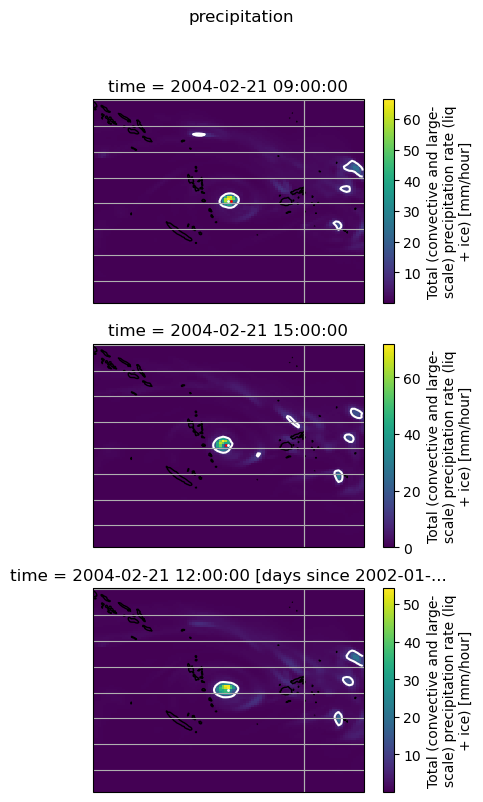

In [38]:
dt = 40
dsi = ds_tracks.isel(id=101, dtime=dt)
ds0 = ds_tracks.isel(id=101, dtime=dt-1)
ds1 = ds_tracks.isel(id=101, dtime=dt+1)

da = preprocess_precipitation(ds_cam['h2'])
# da = ds_cam['h2'].PRECT.copy()
# da.data *= 3.6e6
# da.attrs['units'] = 'mm/hour'
# if 'time: mean' in getattr(da,'cell_methods',''):
#     da['time'] = ('time', (da.time - datetime.timedelta(hours=1, minutes=30)).data, da.time.attrs)
# t = da.time.coarsen(time=2).mean(keep_attrs=True)
# da = da.coarsen(time=2).mean(keep_attrs=True)
# da['time'] = t

dd = 50 # 
t = np.searchsorted(da.time, dsi.cftime)
x = np.searchsorted(da.lon, dsi.lon)
y = np.searchsorted(da.lat, dsi.lat)
Z0 = da[t-1,y-dd:y+dd+1,x-dd:x+dd+1].compute()
Z1 = da[t,y-dd:y+dd+1,x-dd:x+dd+1].compute()
Zi = da.interp(time=dsi.cftime)[y-dd:y+dd+1,x-dd:x+dd+1].compute()

print(f"time={str(dsi.cftime.item())}, {t=}, {x=}, {y=}")
print(f"{np.max(Zi).item()=}, {dsi.PRECT.item()=}")

fig,axs = plt.subplots(3,1,figsize=(5,9),sharex=True, sharey=True, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

axs[0].plot(ds0.lon, ds0.lat, 'o', markersize=1, c='r', transform=ccrs.PlateCarree())
axs[1].plot(ds1.lon, ds1.lat, 'o', markersize=1, c='r', transform=ccrs.PlateCarree())
for ax,Z in zip(axs,[Z0,Z1,Zi]):
    Z.plot(ax=ax, transform=ccrs.PlateCarree())
    cs = (Z/Z.max()).plot.contour(ax=ax, levels=[0.15], colors=['white'], transform=ccrs.PlateCarree())
    ax.clabel(cs)
    ax.coastlines()
    ax.plot(dsi.lon, dsi.lat, 'o', markersize=1, c='white', transform=ccrs.PlateCarree())
    ax.gridlines()

fig.suptitle("precipitation")

t=np.int64(3579), x=np.int64(548), y=np.int64(308)


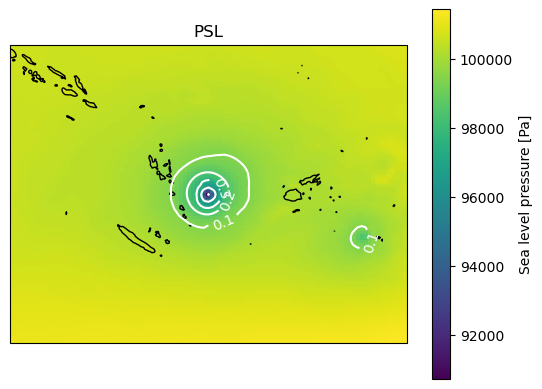

In [39]:
#dt = 5
dsi = ds_tracks.isel(id=101, dtime=dt)
da = ds_cam['h1'].PSL
#dd = 10
t = np.searchsorted(da.time, dsi.cftime)
x = np.searchsorted(da.lon, dsi.lon)
y = np.searchsorted(da.lat, dsi.lat)
Z = da[t,y-dd:y+dd+1,x-dd:x+dd+1]
print(f"{t=}, {x=}, {y=}")

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
Z.plot(ax=ax, transform=ccrs.PlateCarree())
cs = ((Z-Z.mean())/(Z.min()-Z.mean())).plot.contour(ax=ax, levels=[0.1,0.2,0.3,0.5], colors=['white'], transform=ccrs.PlateCarree())
ax.clabel(cs)
ax.plot(dsi.lon, dsi.lat, 'o', markersize=1, c='white', transform=ccrs.PlateCarree())
ax.coastlines()
_=ax.set_title("PSL")

t=np.int64(3579), x=np.int64(548), y=np.int64(308)


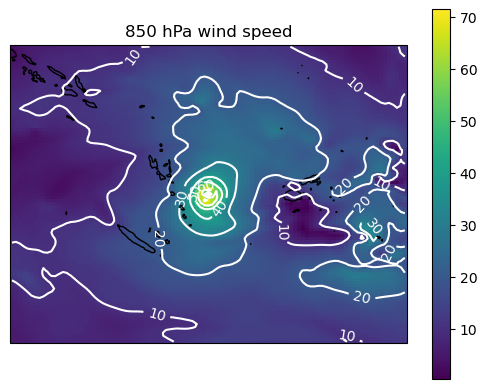

In [40]:
#dt = 5
dsi = ds_tracks.isel(id=101, dtime=dt)
da = np.sqrt(ds_cam['h1'].U850**2 + ds_cam['h1'].V850**2)
#dd = 10
t = np.searchsorted(da.time, dsi.cftime)
x = np.searchsorted(da.lon, dsi.lon)
y = np.searchsorted(da.lat, dsi.lat)
Z = da[t,y-dd:y+dd+1,x-dd:x+dd+1]
U = ds_cam['h1'].U850[t,y-dd:y+dd+1,x-dd:x+dd+1]
V = ds_cam['h1'].V850[t,y-dd:y+dd+1,x-dd:x+dd+1]
print(f"{t=}, {x=}, {y=}")

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
Z.plot(ax=ax, transform=ccrs.PlateCarree())
cs = Z.plot.contour(ax=ax, levels=range(0,100,10), colors=['white'], transform=ccrs.PlateCarree())
ax.clabel(cs)
try:
    ax.quiver(U.lon.data, U.lat.data, U.data, V.data, transform=ccrs.PlateCarree())
except:
    pass
ax.plot(dsi.lon, dsi.lat, 'o', markersize=1, c='white', transform=ccrs.PlateCarree())
ax.coastlines()
_=ax.set_title("850 hPa wind speed")

In [6]:
(5-1)/2

2.0

In [45]:
def load_CAMprec(track, camdata, pad=40):
    """Load CAM precipitation data for a specific track
    
        
    track: xr.Dataset
        track coordinates
    cam: xr.Dataset
        full CAM precipitation dataset
    pad: int
        number of grid points to add around track

    returns: xr.Dataset
        selection of full CAM precipitation data 
    """
    tslice = slice(track.cftime.min().item().strftime('%Y-%m-%d %H:%M'),
                   track.cftime.max().item().strftime('%Y-%m-%d %H:%M'))
    yrange = slice(camdata.lat.searchsorted(track.lat.min())-pad,
                   camdata.lat.searchsorted(track.lat.max())+pad+1)
    result = camdata.sel(time=tslice).isel(lat=yrange)
    return result

track = ds_tracks.isel(id=101)
camdata = preprocess_precipitation(ds_cam['h2'])
print(load_CAMprec(track, camdata))

<xarray.DataArray 'PRECT' (time: 60, lat: 134, lon: 1152)> Size: 37MB
dask.array<getitem, shape=(60, 134, 1152), dtype=float32, chunksize=(1, 134, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -37.67 -37.43 -37.2 ... -6.923 -6.688 -6.454
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * time     (time) object 480B 2004-02-16 15:00:00 ... 2004-03-03 09:00:00
Attributes:
    units:         mm/hour
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean


In [15]:
180/0.23

782.6086956521739

dx=19, dy=40


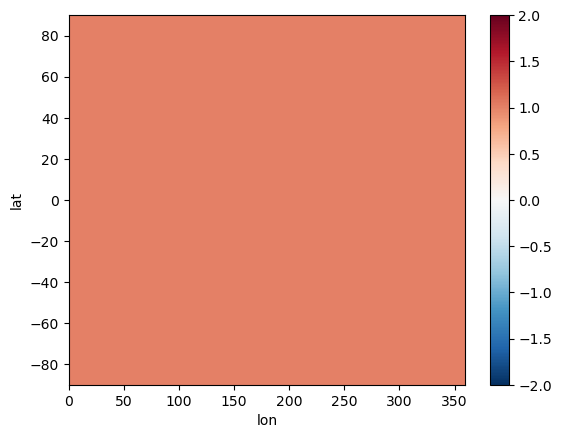

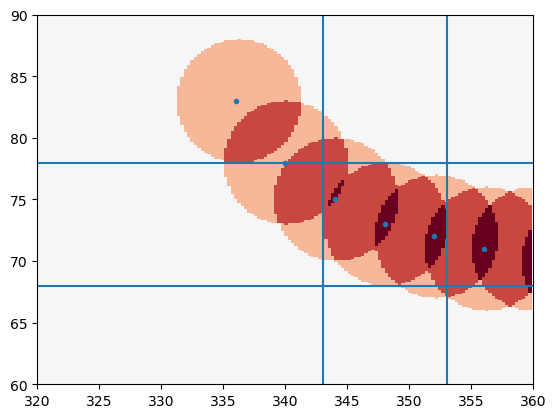

In [37]:
track = {'lon': [4,0,356,352,348,344,340,336], 'lat': [70,71,71,72,73,75,78,83]}
Nlons = 1334 # number of longitudes (total)
Nlats = 1440 # number of latitudes (total)
# d = 20
d = 5 # radius in degrees!
dx = round(d*Nlons/360)
dy = round(d*Nlats/180)
print(f"{dx=}, {dy=}")
# circlemask = np.sqrt(np.arange(-d,d+1)[None,:]**2 + np.arange(-d,d+1)[:,None]**2) <= d
circlemask = np.sqrt((360/Nlons*np.arange(-dx,dx+1)[None,:])**2 + (180/Nlats*np.arange(-dy,dy+1)[:,None])**2) <= d
lons = np.arange(0,360,360/Nlons)
lats = np.arange(-90,90,180/Nlats)
pcip = xr.DataArray(np.sin(lons/180*np.pi)[None,:]+(lats/90)[:,None], coords={'lon':lons,'lat':lats}, dims=('lat','lon'))
pcip = xr.ones_like(pcip)
pcip.plot(cmap='RdBu_r', vmin=-2, vmax=2)
plt.show()

newpcip = xr.zeros_like(pcip)

for lon, lat in zip(track['lon'], track['lat']):
    x = np.searchsorted(lons, lon)
    y = np.searchsorted(lats, lat)
    xs = np.arange(x-dx,x+dx+1,)%len(lons)
    ys = np.arange(max(y-dy,0),min(y+dy+1,len(lats)))
    newpcip[ys,xs] += pcip[ys,xs] * circlemask


plt.pcolormesh(lons, lats, newpcip.data, cmap='RdBu_r', vmin=-3, vmax=3)
plt.plot(track['lon'], track['lat'], '.')
plt.gca().axhline(track['lat'][4]-d)
plt.gca().axhline(track['lat'][4]+d)
plt.gca().axvline(track['lon'][4]-d)
plt.gca().axvline(track['lon'][4]+d)
plt.xlim([320,360])
plt.ylim([60,90])
plt.show()

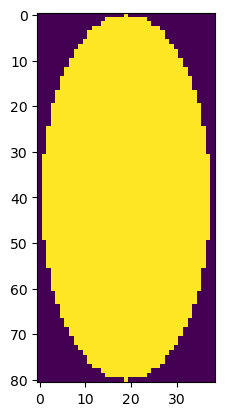

In [34]:
plt.imshow(circlemask)

# Results precipitation sum

In [3]:
cam = xr.open_dataset("/home/jasperdj/sai-git/sai/jobs/climate_results/PRECT/data/precipitation.nc")
tc = xr.open_dataset("/home/jasperdj/TCs-under-SAI/tracker/additional/precipitation_sum/data/pcip_sum.nc")


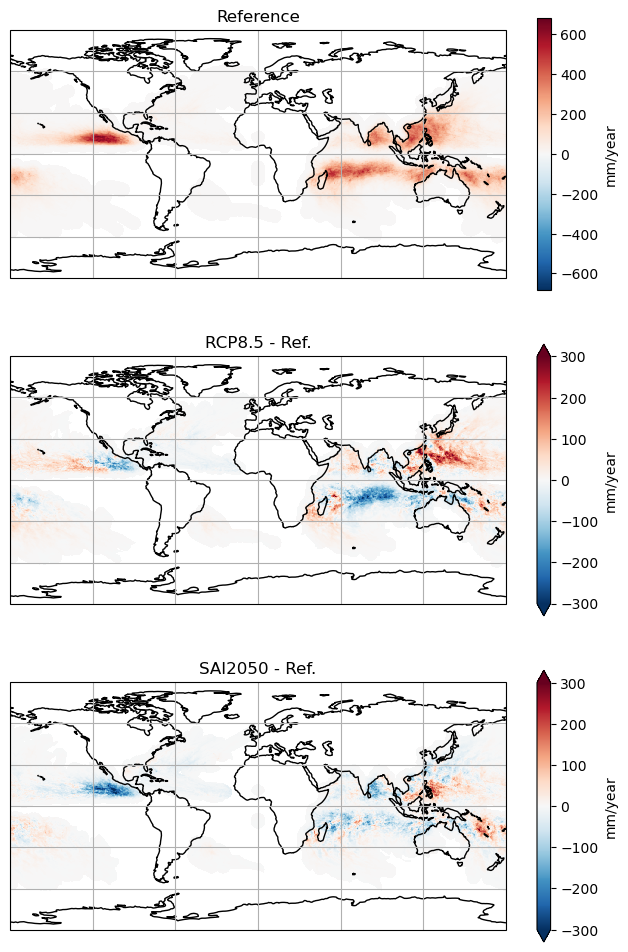

In [39]:
# annual TC precipitation sum plots
fig, axs = plt.subplots(3,1, figsize=(8,12), sharex=True, sharey=True, subplot_kw={'projection':ccrs.PlateCarree()})

ax = axs[0]
tc.sel(exp='ref').PRECT.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'mm/year'})
ax.set_title('Reference')

vmin = -300
vmax = 300
ax=axs[1]
(tc.sel(exp='cnt').PRECT - tc.sel(exp='ref').PRECT).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='RdBu_r', transform=ccrs.PlateCarree(), cbar_kwargs={'label':'mm/year'})
ax.set_title('RCP8.5 - Ref.')

ax=axs[2]
(tc.sel(exp='sai').PRECT - tc.sel(exp='ref').PRECT).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='RdBu_r', transform=ccrs.PlateCarree(), cbar_kwargs={'label':'mm/year'})
ax.set_title('SAI2050 - Ref.')

for ax in axs:
    ax.coastlines()
    ax.gridlines()

Text(0.5, 0.98, 'standard deviation of annual TC precipitation sum')

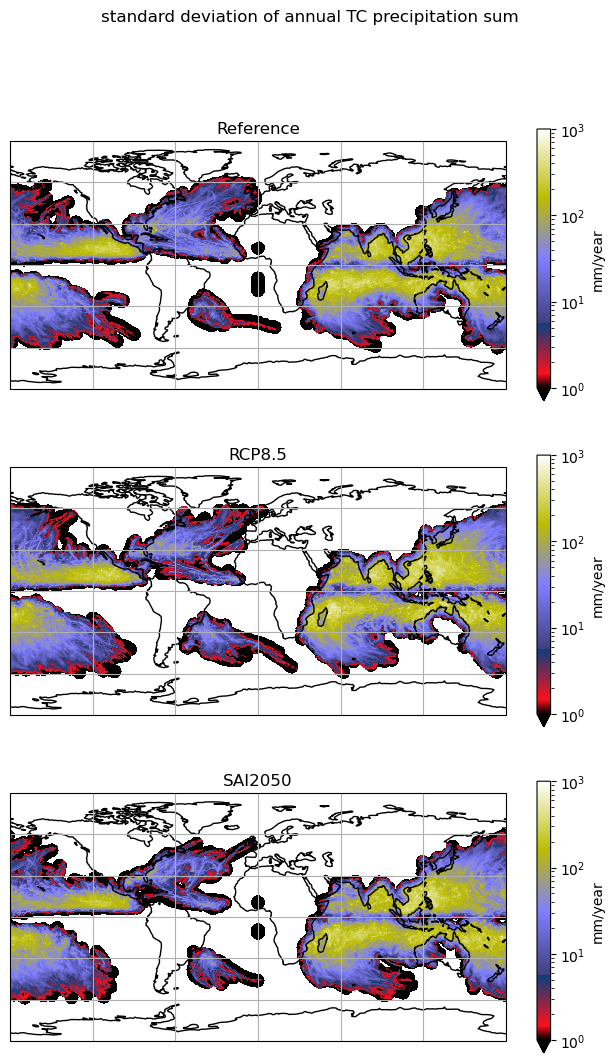

In [37]:
# Standard deviation of annual TC precipitation plots
norm = mcolors.LogNorm(1,1000)

kwargs = dict(norm=norm, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'mm/year'}, cmap='gist_stern')
fig, axs = plt.subplots(3,1, figsize=(8,12), sharex=True, sharey=True, subplot_kw={'projection':ccrs.PlateCarree()})

tc = tc.where(tc.PRECT!=0)

ax = axs[0]
tc.sel(exp='ref').PRECT_std.plot(ax=ax, **kwargs)
ax.set_title('Reference')

ax=axs[1]
tc.sel(exp='cnt').PRECT_std.plot(ax=ax, **kwargs)
ax.set_title('RCP8.5')

ax=axs[2]
tc.sel(exp='sai').PRECT_std.plot(ax=ax, **kwargs)
ax.set_title('SAI2050')

for ax in axs:
    ax.coastlines()
    ax.gridlines()

fig.suptitle("standard deviation of annual TC precipitation sum")